### reset the graph

In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.python.framework import graph_util
import tfcoreml  as tfconverter

tf.reset_default_graph()

### prepare training data

In [2]:
tf.logging.set_verbosity(tf.logging.ERROR)

# download to mnist_data/ folder
mnist_data = input_data.read_data_sets('mnist_data', one_hot=True, reshape=False, validation_size=0)

tf.logging.set_verbosity(tf.logging.DEBUG)

Extracting mnist_data/train-images-idx3-ubyte.gz
Extracting mnist_data/train-labels-idx1-ubyte.gz
Extracting mnist_data/t10k-images-idx3-ubyte.gz
Extracting mnist_data/t10k-labels-idx1-ubyte.gz


### create computal graph

In [3]:
# y = softmax(Weights * x) + biases
x = tf.placeholder(tf.float32, [None, 28, 28, 1], name='input_image')
y = tf.placeholder(tf.float32, [None, 10], name='y')
# 10個神經元, 28 x 28 = 784 px image
weights = tf.Variable(tf.zeros([784, 10]), name='weights')
biases = tf.Variable(tf.zeros([10]), name='biases')

flattenX = tf.reshape(x, [-1, 784], name='flattenX')
# Weights * x = [784, 10] x [100, 784] ==> crash
# x * Weights = [10, 784] x [784, 100] ==> [100, 10]
WX = tf.matmul(flattenX, weights, name='WX')
# 演算出來的答案 [100, 10] ==> 一百張圖，個別 label 的信心程度
finalY = tf.nn.softmax(WX + biases, name='prediction')

### loss function

In [4]:
# Cross-entropy(適合分類): loss = - sum(y * log(finalY))

# A = [[1, 2], [3, 4]] ==> Shape: [2, 2]
# B = [[5, 6], [7, 8]] ==> Shape: [2, 2]
# A * B = [[1 * 5,  2 * 6], [3 * 7, 4 * 8]] ==> Shape: [2, 2]

# y ==> Shape: [None, 10]
# finalY ==> Shape: [None, 10]
# tf.log(finalY) ==> Shape: [None, 10]
# y * tf.log(finalY) ==> Shape: [None, 10]

# tf.reduce_mean(..., axis = 0) ==> [10]
# 10 ==> 10種結果, 100 ==> 一次100張圖片
loss = - tf.reduce_mean(y * tf.log(finalY)) * 10 * 100
# loss = - tf.reduce_sum(y * tf.log(finalY)) * 10
optimizer = tf.train.GradientDescentOptimizer(0.01)
train = optimizer.minimize(loss)

### extra job for accuracy

In [5]:
correct_predition = tf.equal(tf.arg_max(finalY, 1), tf.arg_max(y, 1)) # True or False [100]
# tf.cast(轉型)
accuracy = tf.reduce_mean(tf.cast(correct_predition, tf.float32))

Instructions for updating:
Use `argmax` instead


### run the session

In [6]:
accuracy_result = []
loss_result = []

with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    
    # prepare saver
    saver = tf.train.Saver()
    
    # try to restore *.ckpt
    exist = tf.train.get_checkpoint_state('./save/')
    if exist:
        saver.restore(session, './save/hand_write.ckpt')
        print('Restore success.')
    else:
        print('No exist check point.')
    
    for step in range(2000):
        # get the training data from file
        batchX, batchY = mnist_data.train.next_batch(100)
        session.run(train, feed_dict = {
            x: batchX,
            y: batchY
        })
        # show the training progress
        accuracy_batch, loss_batch = session.run([accuracy, loss], feed_dict = {
            x: batchX,
            y: batchY
        })
        # print(step, 'train: ', accuracy_batch, loss_batch)
        
        testX = mnist_data.test.images
        testY = mnist_data.test.labels
        accuracy_test, loss_test = session.run([accuracy, loss], feed_dict = {
            x: testX,
            y: testY
        })
        # print(step, 'train: ', accuracy_test, loss_test)
        
        accuracy_result.append({'accuracy_batch': accuracy_batch, 'accuracy_test': accuracy_test})
        loss_result.append({'loss_batch': loss_batch, 'loss_test': loss_test})
        
    # save graph/variables
    # 會用到 session, 要在 session 消失之前執行
    # .ckpt ==> check point 檢查點
    saver.save(session, './save/hand_write.ckpt')
    
    # freeze and save as a pb file
    # 變數轉常數: session + 運算圖 + finalY的名字(prediction)
    frozen_graph = graph_util.convert_variables_to_constants(session, session.graph_def, [finalY.op.name])
    
    # check and let None became 1
    for node in frozen_graph.node:
        # 排除強制使用 GPU
        if node.device:
            node.device = ''
        # shape 預設為 None(未知)
        if 'shape' in node.attr:
            node.attr['shape'].shape.dim[0].size = 1
            
    # save the pb file
    # as_text(important) ==> True: 轉換成文字, False: 轉換成binary格式
    tf.train.write_graph(frozen_graph, '', './frozen/frozen_graph.pb', as_text=False)

No exist check point.
INFO:tensorflow:Froze 2 variables.
INFO:tensorflow:Converted 2 variables to const ops.


### convert pb to coreml file formate

In [7]:
tfconverter.convert(tf_model_path='./frozen/frozen_graph.pb',
                            mlmodel_path='./model_output/MyHandWriteV1.mlmodel',
                            output_feature_names=['prediction:0'],
                            image_input_names=['input_image__0'],
                            class_labels='MyHandWriteV1.txt')


Loading the TF graph...
Graph Loaded.
Done.
Now finding ops in the TF graph that can be dropped for inference
Now starting translation to CoreML graph.
Automatic shape interpretation succeeded for input blob input_image:0
1/10: Analysing op name: flattenX/shape ( type:  Const )
2/10: Analysing op name: biases ( type:  Const )
3/10: Analysing op name: biases/read ( type:  Identity )
4/10: Analysing op name: weights ( type:  Const )
5/10: Analysing op name: weights/read ( type:  Identity )
6/10: Analysing op name: input_image ( type:  Placeholder )
Skipping name of placeholder
7/10: Analysing op name: flattenX ( type:  Reshape )
8/10: Analysing op name: WX ( type:  MatMul )
9/10: Analysing op name: add ( type:  Add )
10/10: Analysing op name: prediction ( type:  Softmax )
Translation to CoreML spec completed. Now compiling and saving the CoreML model.

 Core ML model generated. Saved at location: ./model_output/MyHandWriteV1.mlmodel 

Core ML input(s): 
 [name: "input_image__0"
type {
 

input {
  name: "input_image__0"
  type {
    imageType {
      width: 28
      height: 28
      colorSpace: GRAYSCALE
    }
  }
}
output {
  name: "prediction__0"
  type {
    dictionaryType {
      stringKeyType {
      }
    }
  }
}
output {
  name: "classLabel"
  type {
    stringType {
    }
  }
}
predictedFeatureName: "classLabel"
predictedProbabilitiesName: "prediction__0"

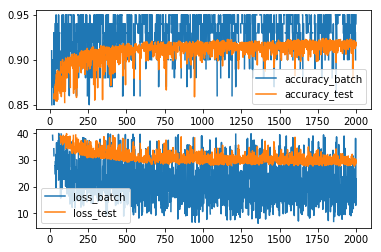

In [8]:
import matplotlib.pyplot as plt
import pandas

%matplotlib inline

pd = pandas.DataFrame(accuracy_result)
pd2 = pandas.DataFrame(loss_result)

pd = pd[(pd > 0.85) & (pd < 0.95)]
pd2 = pd2[pd2 < 40]

fig, axes = plt.subplots(nrows=2, ncols=1)
pd.plot(ax=axes[0])
pd2.plot(ax=axes[1])